## Importing Libraries

In [1]:
import os
import time
import math
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Dataset

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# !kaggle datasets download -d grouplens/movielens-20m-dataset -p /tmp/

 98% 191M/195M [00:02<00:00, 120MB/s]
100% 195M/195M [00:02<00:00, 84.4MB/s]


In [ ]:
# local_training_zip = '/tmp/movielens-20m-dataset.zip'
# if zipfile.is_zipfile(filename=local_training_zip):
#     zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r', compression=0, allowZip64=True)
#     zip_ref.extractall(path='/tmp/')
#     zip_ref.close()
# os.remove(path=local_training_zip)

In [3]:
!kaggle datasets download -d prajitdatta/movielens-100k-dataset -p /tmp/

100% 4.77M/4.77M [00:00<00:00, 5.43MB/s]



In [4]:
local_training_zip = '/tmp/movielens-100k-dataset.zip'
if zipfile.is_zipfile(filename=local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r', compression=0, allowZip64=True)
    zip_ref.extractall(path='/tmp/')
    zip_ref.close()
os.remove(path=local_training_zip)

## Analyzing Dataset

In [ ]:
# movies_df = pd.read_csv('/tmp/movie.csv', sep=',')
# movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
# ratings_df = pd.read_csv('/tmp/rating.csv', sep=',')
# ratings_df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [ ]:
# MAX_USERS_ID = ratings_df['userId'].max()
# MAX_MOVIES_ID = movies_df['movieId'].max()

In [7]:
f = open("/tmp/ml-100k/u.info", "r")
for x in f:
    print(x)

943 users

1682 items

100000 ratings



In [8]:
MAX_USERS_ID = 943
MAX_MOVIES_ID = 1682

In [14]:
train_ratings = pd.read_csv('/tmp/ml-100k/u1.base', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
train_ratings

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [15]:
val_ratings = pd.read_csv('/tmp/ml-100k/u1.test', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
val_ratings

,userId,movieId,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


## Preparing Data

In [16]:
def make_pivot(data, no_of_movies):
    '''
        Input: data => numpy array having info for (user_id, movie_id, ratings)
               no_of_movies => Max. number of movies allocation
        Output: Returns pivot table
               
    '''

    # empty array
    pivot_array = []
    user_ids = np.array(list(set(data[:, 0])), dtype='int')

    # looping over users
    for user_id in user_ids:
        # vector for movies rated by user
        user_rating = np.zeros(shape=no_of_movies)

        # retrieving data for specific user
        user_data = data[np.where(data[:, 0] == user_id)]

        # retrieving rated movie-ids by user & converting it to int dtype
        movie_ids = np.array(user_data[:, 1], dtype='int')

        # updating user ratings
        user_rating[movie_ids-1] = user_data[:, 2]
        # user_rating = (user_rating-np.mean(user_rating))/(max(user_rating)-min(user_rating))
        user_rating = np.insert(arr=user_rating, obj=0, values=user_id, axis=0)

        # appending to pivot table
        pivot_array.append(user_rating)

    return np.array(pivot_array)

In [ ]:
# threshold1 = 10**5                       # 100000
# threshold2 = threshold1 + (5 * 10**4)    # 150000

In [ ]:
# training_data = make_pivot(data=ratings_df.iloc[:threshold1, :-1].values, no_of_movies=MAX_MOVIES_ID)
# val_data = make_pivot(data=ratings_df.iloc[threshold1:threshold2, :-1].values, no_of_movies=MAX_MOVIES_ID)

In [17]:
training_data = make_pivot(data=train_ratings.values, no_of_movies=MAX_MOVIES_ID)
val_data = make_pivot(data=val_ratings.values, no_of_movies=MAX_MOVIES_ID)

In [18]:
# understanding data
columns_data = list(range(1, MAX_MOVIES_ID+1))
columns_data.insert(0, 'user_id')
pd.DataFrame(data=training_data, columns=columns_data)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,1.0,5.0,3.0,4.0,3.0,3.0,0.0,4.0,1.0,5.0,0.0,2.0,0.0,5.0,0.0,5.0,5.0,0.0,4.0,5.0,0.0,1.0,4.0,0.0,0.0,4.0,3.0,0.0,4.0,1.0,3.0,0.0,5.0,0.0,2.0,1.0,0.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,940.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,941.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,942.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Defining Model

In [75]:
class VanillaAutoEncoder:
    def __init__(self, features_dim, latent_dim=64):
        self.features_dim = features_dim
        self.latent_dim = latent_dim

    def build(self):
        # Encoder
        encoder_input = tf.keras.Input(shape=self.features_dim, name='EncoderInput')
        x = tf.keras.layers.Dense(units=512, activation='linear', name='EncoderHiddenLayer1')(encoder_input)
        x = tf.keras.layers.Dense(units=128, activation='linear', name='EncoderHiddenLayer2')(x)
        encoder_output = tf.keras.layers.Dense(units=self.latent_dim, activation='linear', name='EncoderOutput')(x)

        decoder_input = tf.keras.Input(shape=self.latent_dim, name='DecoderInput')
        y = tf.keras.layers.Dense(units=128, activation='linear', name='DecoderHiddenLayer1')(decoder_input)
        y = tf.keras.layers.Dense(units=512, activation='linear', name='DecoderHiddenLayer2')(y)
        decoder_output = tf.keras.layers.Dense(units=self.features_dim, activation='sigmoid', name='DecoderOutput')(y)

        self.encoder = tf.keras.Model(inputs=encoder_input, outputs=encoder_output, name='Encoder')
        self.decoder = tf.keras.Model(inputs=decoder_input, outputs=decoder_output, name='Decoder')
        self.autoencoder = tf.keras.Model(inputs=encoder_input, outputs=self.decoder(self.encoder(encoder_input)), name='AutoEncoder')

## Initializing Model

In [76]:
model = VanillaAutoEncoder(features_dim=MAX_MOVIES_ID, latent_dim=64)
model.build()

In [77]:
model.autoencoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncoderInput (InputLayer)    [(None, 1682)]            0         
_________________________________________________________________
Encoder (Model)              (None, 64)                935616    
_________________________________________________________________
Decoder (Model)              (None, 1682)              937234    
Total params: 1,872,850
Trainable params: 1,872,850
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncoderInput (InputLayer)    [(None, 1682)]            0         
_________________________________________________________________
EncoderHiddenLayer1 (Dense)  (None, 512)               861696    
_________________________________________________________________
EncoderHiddenLayer2 (Dense)  (None, 128)               65664     
_________________________________________________________________
EncoderOutput (Dense)        (None, 64)                8256      
Total params: 935,616
Trainable params: 935,616
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DecoderInput (InputLayer)    [(None, 64)]              0         
_________________________________________________________________
DecoderHiddenLayer1 (Dense)  (None, 128)               8320      
_________________________________________________________________
DecoderHiddenLayer2 (Dense)  (None, 512)               66048     
_________________________________________________________________
DecoderOutput (Dense)        (None, 1682)              862866    
Total params: 937,234
Trainable params: 937,234
Non-trainable params: 0
_________________________________________________________________


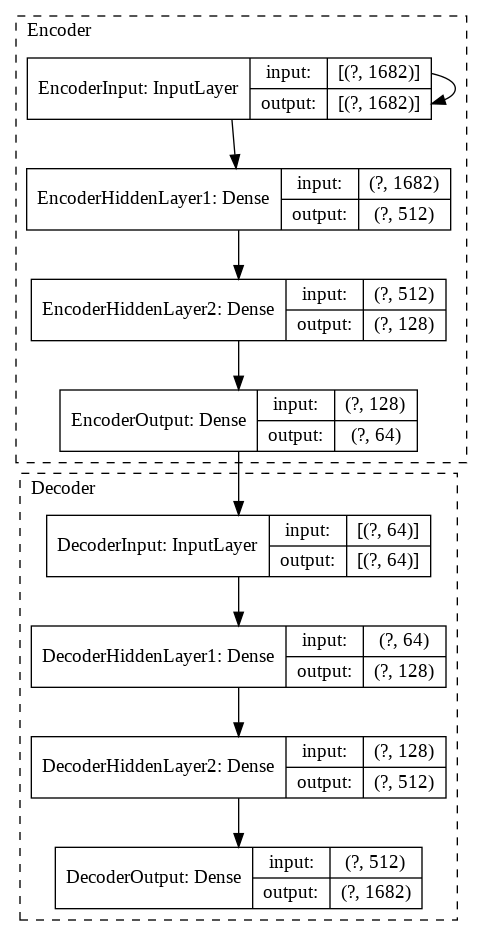

In [80]:
tf.keras.utils.plot_model(
    model=model.autoencoder,
    to_file='AutoEncoder.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)

## Defining Loss Function

In [81]:
def recommender_loss(y_true, y_pred):
    # mask function
    mask_true = tf.cast(x=tf.math.not_equal(x=y_true, y=0), dtype=tf.float32)

    # mask rmse
    return tf.sqrt(tf.reduce_sum(tf.square(mask_true * tf.subtract(y_true, y_pred)), axis=-1))/tf.math.maximum(x=tf.reduce_sum(mask_true, axis=-1), y=1)

## Set-up for Model

In [82]:
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.01

In [83]:
x_train, x_val = training_data[:, 1:], val_data[:, 1:]

In [84]:
TRAIN_BATCH_SIZE = x_train.shape[0]//BATCH_SIZE
VAL_BATCH_SIZE = x_val.shape[0]//BATCH_SIZE

## Compiling Model

In [85]:
model.autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), loss=recommender_loss)

## Training Model

In [86]:
history = model.autoencoder.fit(
    x=x_train,
    y=x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_BATCH_SIZE,
    validation_data=(x_val, x_val),
    validation_steps=VAL_BATCH_SIZE,
    shuffle=True,
    verbose=1
)

Epoch 1/20
29/29 [==============================] - 0s 12ms/step - loss: 0.4261 - val_loss: 0.6246
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4246 - val_loss: 0.6246
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4247 - val_loss: 0.6243
Epoch 4/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4178 - val_loss: 0.6243
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 0.4196 - val_loss: 0.6252
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4270 - val_loss: 0.6241
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4201 - val_loss: 0.6236
Epoch 8/20
29/29 [==============================] - 0s 8ms/step - loss: 0.4224 - val_loss: 0.6236
Epoch 9/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4197 - val_loss: 0.6232
Epoch 10/20
29/29 [==============================] - 0s 9ms/step - loss: 0.4176 - val_loss: 0.6232
Epoch 11/20
29/29 

## Analyzing Model

In [87]:
def plot_result(history, components=['loss', 'val_loss'], colors=['b','r'], labels=['Training loss', 'Validation loss'], locs=[5, -10]):
    '''
        Input: history => model training information
               component => element of data
               color => color to be used for plotting
               label => text for defining plots
        Output: plot of data component
    '''
    
    plt.figure(figsize=(20, 6))
    for component, color, label, loc in zip(components, colors, labels, locs):
        plt.plot(history.history[component], marker='o', color=color, label=label)
        plt.title('Loss')
        plt.legend()
        plt.xticks(history.epoch)
        for x, y in zip(history.epoch, history.history[component]):
            label = "{:.3f}".format(y)
            plt.annotate(label,                               # this is the text
                         (x, y),                              # this is the point to label
                         textcoords="offset points",          # how to position the text
                         xytext=(0, loc),                       # distance from text to points (x,y)
                         ha='center')                         # horizontal alignment can be left, right or center

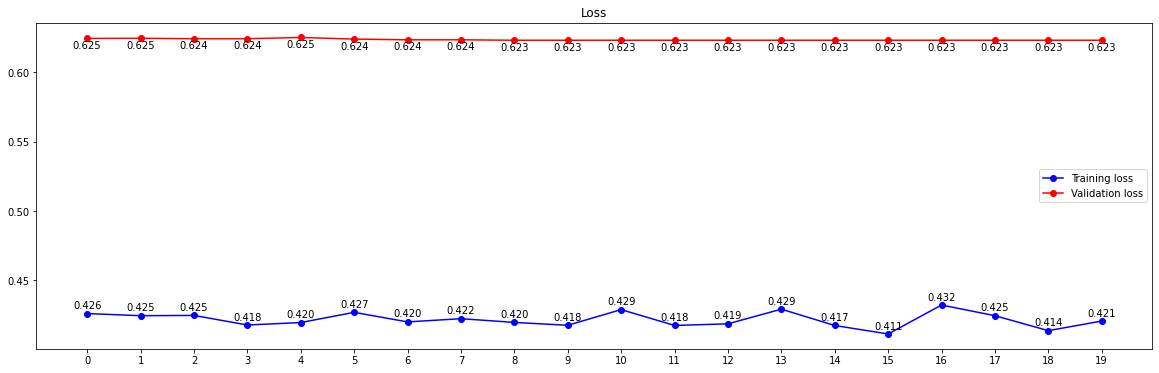

In [88]:
plot_result(history=history)

+ The results are not so good as it was train on less number of training examples.